In [1]:
# common imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning imports
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# display setup
pd.set_option("display.max_columns", None) # the None parameter displays unlimited columns
sns.set(style="whitegrid") # for plots

# Preface
* Fashion-MNIST is a dataset containing 70,000 samples, 60,000 for the training set and 10,000 for the test set.
* Each sample is a 28x28 (784 pixels) grayscale image of a certain fashion item.
* The data contains a column with 10 labels, making this a **multiclass classification** problem.
In other words, this is a **supervised learning** task.
* The model will be trained using all available data and run without learning anymore. This method is named **offline/batch learning**.
* Main objective: Find the best algorithm and model parameters that classify the unused images correctly.

# 1. Getting the Data

In [2]:
# read the csv file
train_set = pd.read_csv(r"FMNIST/fashion-mnist_train.csv")
test_set = pd.read_csv(r"FMNIST/fashion-mnist_test.csv")

In [3]:
# display the first 5 rows for a quick look
train_set.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,pixel249,pixel250,pixel251,pixel252,pixel253,pixel254,pixel255,pixel256,pixel257,pixel258,pixel259,pixel260,pixel261,pixel262,pixel263,pixel264,pixel265,pixel266,pixel267,pixel268,pixel269,pixel270,pixel271,pixel272,pixel273,pixel274,pixel275,pixel276,pixel277,pixel278,pixel279,pixel280,pixel281,pixel282,pixel283,pixel284,pixel285,pixel286,pixel287,pixel288,pixel289,pixel290,pixel291,pixel292,pixel293,pixel294,pixel295,pixel296,pixel297,pixel298,pixel299,pixel300,pixel301,pixel302,pixel303,pixel304,pixel305,pixel306,pixel307,pixel308,pixel309,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319,pixel320,pixel321,pixel322,pixel323,pixel324,pixel325,pixel326,pixel327,pixel328,pixel329,pixel330,pixel331,pixel332,pixel333,pixel334,pixel335,pixel336,pixel337,pixel338,pixel339,pixel340,pixel341,pixel342,pixel343,pixel344,pixel345,pixel346,pixel347,pixel348,pixel349,pixel350,pixel351,pixel352,pixel353,pixel354,pixel355,pixel356,pixel357,pixel358,pixel359,pixel360,pixel361,pixel362,pixel363,pixel364,pixel365,pixel366,pixel367,pixel368,pixel369,pixel370,pixel371,pixel372,pixel373,pixel374,pixel375,pixel376,pixel377,pixel378,pixel379,pixel380,pixel381,pixel382,pixel383,pixel384,pixel385,pixel386,pixel387,pixel388,pixel389,pixel390,pixel391,pixel392,pixel393,pixel394,pixel395,pixel396,pixel397,pixel398,pixel399,pixel400,pixel401,pixel402,pixel403,pixel404,pixel405,pixel406,pixel407,pixel408,pixel409,pixel410,pixel411,pixel412,pixel413,pixel414,pixel415,pixel416,pixel417,pixel418,pixel419,pixel420,pixel421,pixel422,pixel423,pixel424,pixel425,pixel426,pixel427,pixel428,pixel429,pixel430,pixel431,pixel432,pixel433,pixel434,pixel435,pixel436,pixel437,pixel438,pixel439,pixel440,pixel441,pixel442,pixel443,pixel444,pixel445,pixel446,pixel447,pixel448,pixel449,pixel450,pixel451,pixel452,pixel453,pixel454,pixel455,pixel4

In [4]:
# display the last 5 rows for a quick look
train_set.tail()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,pixel249,pixel250,pixel251,pixel252,pixel253,pixel254,pixel255,pixel256,pixel257,pixel258,pixel259,pixel260,pixel261,pixel262,pixel263,pixel264,pixel265,pixel266,pixel267,pixel268,pixel269,pixel270,pixel271,pixel272,pixel273,pixel274,pixel275,pixel276,pixel277,pixel278,pixel279,pixel280,pixel281,pixel282,pixel283,pixel284,pixel285,pixel286,pixel287,pixel288,pixel289,pixel290,pixel291,pixel292,pixel293,pixel294,pixel295,pixel296,pixel297,pixel298,pixel299,pixel300,pixel301,pixel302,pixel303,pixel304,pixel305,pixel306,pixel307,pixel308,pixel309,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319,pixel320,pixel321,pixel322,pixel323,pixel324,pixel325,pixel326,pixel327,pixel328,pixel329,pixel330,pixel331,pixel332,pixel333,pixel334,pixel335,pixel336,pixel337,pixel338,pixel339,pixel340,pixel341,pixel342,pixel343,pixel344,pixel345,pixel346,pixel347,pixel348,pixel349,pixel350,pixel351,pixel352,pixel353,pixel354,pixel355,pixel356,pixel357,pixel358,pixel359,pixel360,pixel361,pixel362,pixel363,pixel364,pixel365,pixel366,pixel367,pixel368,pixel369,pixel370,pixel371,pixel372,pixel373,pixel374,pixel375,pixel376,pixel377,pixel378,pixel379,pixel380,pixel381,pixel382,pixel383,pixel384,pixel385,pixel386,pixel387,pixel388,pixel389,pixel390,pixel391,pixel392,pixel393,pixel394,pixel395,pixel396,pixel397,pixel398,pixel399,pixel400,pixel401,pixel402,pixel403,pixel404,pixel405,pixel406,pixel407,pixel408,pixel409,pixel410,pixel411,pixel412,pixel413,pixel414,pixel415,pixel416,pixel417,pixel418,pixel419,pixel420,pixel421,pixel422,pixel423,pixel424,pixel425,pixel426,pixel427,pixel428,pixel429,pixel430,pixel431,pixel432,pixel433,pixel434,pixel435,pixel436,pixel437,pixel438,pixel439,pixel440,pixel441,pixel442,pixel443,pixel444,pixel445,pixel446,pixel447,pixel448,pixel449,pixel450,pixel451,pixel452,pixel453,pixel454,pixel455,pixel4

In [5]:
# description of data
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB


In [6]:
# summary of the numerical attributes
# null values are ignored
train_set.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,pixel249,pixel250,pixel251,pixel252,pixel253,pixel254,pixel255,pixel256,pixel257,pixel258,pixel259,pixel260,pixel261,pixel262,pixel263,pixel264,pixel265,pixel266,pixel267,pixel268,pixel269,pixel270,pixel271,pixel272,pixel273,pixel274,pixel275,pixel276,pixel277,pixel278,pixel279,pixel280,pixel281,pixel282,pixel283,pixel284,pixel285,pixel286,pixel287,pixel288,pixel289,pixel290,pixel291,pixel292,pixel293,pixel294,pixel295,pixel296,pixel297,pixel298,pixel299,pixel300,pixel301,pixel302,pixel303,pixel304,pixel305,pixel306,pixel307,pixel308,pixel309,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319,pixel320,pixel321,pixel322,pixel323,pixel324,pixel325,pixel326,pixel327,pixel328,pixel329,pixel330,pixel331,pixel332,pixel333,pixel334,pixel335,pixel336,pixel337,pixel338,pixel339,pixel340,pixel341,pixel342,pixel343,pixel344,pixel345,pixel346,pixel347,pixel348,pixel349,pixel350,pixel351,pixel352,pixel353,pixel354,pixel355,pixel356,pixel357,pixel358,pixel359,pixel360,pixel361,pixel362,pixel363,pixel364,pixel365,pixel366,pixel367,pixel368,pixel369,pixel370,pixel371,pixel372,pixel373,pixel374,pixel375,pixel376,pixel377,pixel378,pixel379,pixel380,pixel381,pixel382,pixel383,pixel384,pixel385,pixel386,pixel387,pixel388,pixel389,pixel390,pixel391,pixel392,pixel393,pixel394,pixel395,pixel396,pixel397,pixel398,pixel399,pixel400,pixel401,pixel402,pixel403,pixel404,pixel405,pixel406,pixel407,pixel408,pixel409,pixel410,pixel411,pixel412,pixel413,pixel414,pixel415,pixel416,pixel417,pixel418,pixel419,pixel420,pixel421,pixel422,pixel423,pixel424,pixel425,pixel426,pixel427,pixel428,pixel429,pixel430,pixel431,pixel432,pixel433,pixel434,pixel435,pixel436,pixel437,pixel438,pixel439,pixel440,pixel441,pixel442,pixel443,pixel444,pixel445,pixel446,pixel447,pixel448,pixel449,pixel450,pixel451,pixel452,pixel453,pixel454,pixel455,pixel4

In [7]:
# DataFrame shape (rows, columns)
print("Training Set:", train_set.shape)
print("Test Set:", test_set.shape)

Training Set: (60000, 785)
Test Set: (10000, 785)


> Note: There are 785 columns, one for the labels and 784 for the pixels.

In [8]:
labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
# number of instances for each category
train_set["label"].value_counts()

0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
Name: label, dtype: int64

> Labels:
> - 0 = T-shirt/top
> - 1 = Trouser
> - 2 = Pullover
> - 3 = Dress
> - 4 = Coat
> - 5 = Sandal
> - 6 = Shirt
> - 7 = Sneaker
> - 8 = Bag
> - 9 = Ankle boot
>
>> Observation: Each category has an equal amount of samples.

# 2. Understanding and Visualizing the Data
> ##### *The motivation for this section is to gain more insights.*
>
> In this case- each instance is an image and each feature represents a pixel.
> This section is mainly dedicated towards finding the transformations that suit the data best.
>
> **How I plan to achieve this:**
>
> Train baseline models using various data transformations on the training set, and compare their results.

The data is split beforehand, and the images are already scaled to the same size.
Let's create a copy of the data to prevent accidentally harming the training set.

In [9]:
# deep copy of the training set
df = train_set.copy()

In [10]:
# check for missing values
np.isnan(df.values).sum()

0

In [11]:
# DataFrame shape (rows, columns)
# understand the amount of data we are working with
df.shape

(60000, 785)

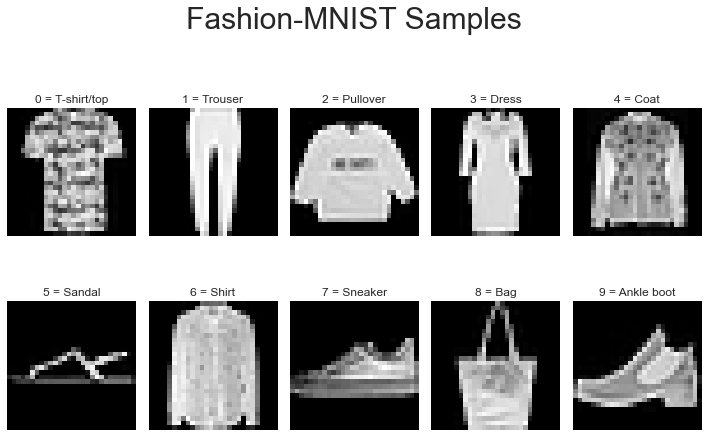

In [12]:
# plot image for each category

# use of a dictionary to easily add subplot titles
label_dict = {0:"0 = T-shirt/top", 1:"1 = Trouser", 2:"2 = Pullover", 3:"3 = Dress", 4:"4 = Coat",
              5:"5 = Sandal", 6:"6 = Shirt", 7:"7 = Sneaker", 8:"8 = Bag", 9:"9 = Ankle boot"}

fig = plt.figure(figsize=(10,7))
rows = 2
columns = 5
# use groupby to locate an instance for each label
label_groups = df.groupby('label')
# add image in each iteration
for i in range(rows*columns):
    curr = label_groups.get_group(i)[:1]
    curr_img = curr.drop('label', axis = 1).to_numpy().reshape(28,28)
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(curr_img, plt.cm.gray)
    plt.axis('off')
    plt.title(label_dict[i])
fig.suptitle("Fashion-MNIST Samples", size=30)
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(12,7))
rows = 2
columns = 5
mean_values = []

for i in range(10):
    pixels = np.array(label_groups.get_group(i).drop(['label'], axis=1))
    mean_values.append(pixels.mean())
    fig.add_subplot(rows, columns, i+1)
    plt.hist(pixels.reshape(-1))
    plt.title(label_dict[i])
fig.suptitle("Fashion-MNIST Samples", size=30)
fig.align_ylabels()
plt.tight_layout()
plt.show()

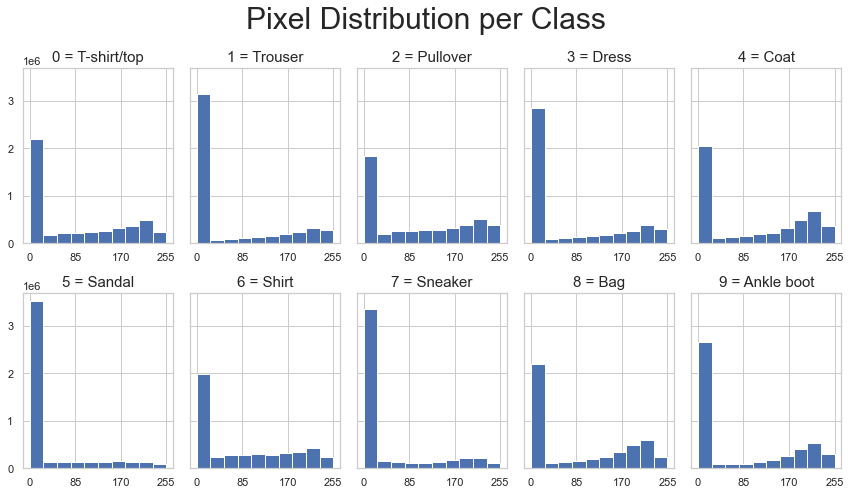

In [13]:
fig, dx = plt.subplots(2,5, figsize=(12, 7), sharey=True)
i = 0
mean_values = []
plt.setp(dx, xticks=np.arange(0, 256, step=85))

for row in [0,1]:
    for col in range(5):
        pixels = np.array(label_groups.get_group(i).drop(['label'], axis=1))
        mean_values.append(pixels.mean())
        dx[row,col].hist(pixels.reshape(-1))
        dx[row,col].set_title(label_dict[i], size=15)
        i = i + 1

fig.suptitle("Pixel Distribution per Class", size=30)
plt.tight_layout()
plt.show()

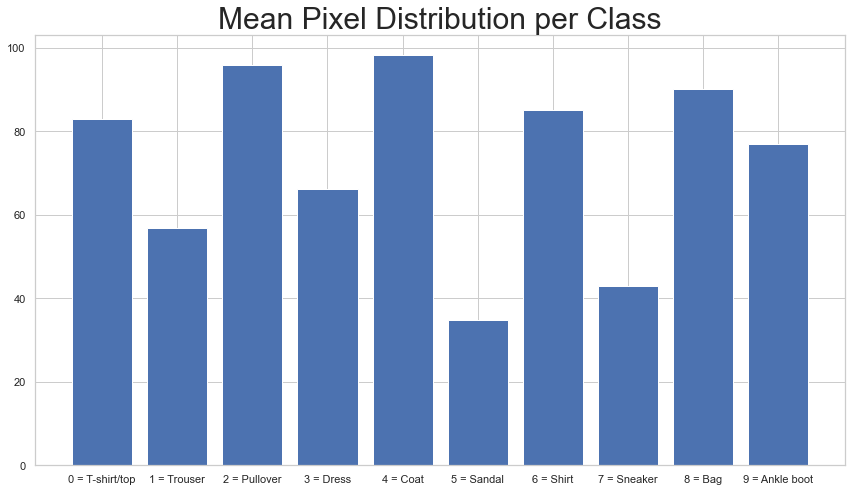

In [14]:
plt.figure(figsize=(12,7))
plt.bar(np.arange(10), mean_values)
plt.xticks(np.arange(10), labels=label_dict.values())
plt.title("Mean Pixel Distribution per Class", size=30)
plt.tight_layout()
plt.show()

# 3. Data Cleaning

In [15]:
# clean copy of the training set
df3 = train_set.copy()

In [16]:
# separate features from target values

# drop- creates a copy without changing the training set
X_train = df3.drop('label', axis=1)

# create a deep copy of the target values
y_train = df3['label'].copy()

Although the pixel values are in a known range [0,255], scaling the data can make a crucial difference
(especially if the learning algorithm relies on calculating distances).

> Why is this important?
* Models can't differentiate feature importance the same way humans can.
A training algorithm may assume that a feature containing large numbers is more important than features
with smaller numbers- which might not be the case.
* Some algorithms converge much faster when features are scaled (i.e. Gradient Descent).
* There are ML algorithms that make assumptions on the data (i.e. PCA assumes the data is centered around
the origin).
>

Chosen feature scale:

Standardizing centers the data so that it has a zero mean and a standard deviation of 1, under the assumption
that the data is normally distributed.

* The distribution is relatively normal (aside from the black pixels which is highest in all classes).
* Using PCA could be useful since the dataset has a large amount of features. As previously stated,
PCA assumes the data has zero mean.

Therefore, standard scaling seems to be the ideal option.

# 4. Training and Evaluating Models

>

> Accuracy is less relevant for an imbalanced classification problem.
> Evaluating by a metric that represents the data better is important.
>
> Chosen evaluation metric:
>
> The F1 Score is calculated by using precision (the accuracy of the positive predictions) and
> recall (the ratio of positive instances correctly classified) accuracy.
> This metric gives a higher value towards false positives rather than false negatives.

In [17]:
# function prints scores
def display_evaluation(actual, pred):
    print("Confusion Matrix:\n", metrics.confusion_matrix(actual, pred), "\n")
    print("Classification Report:\n", metrics.classification_report(actual, pred))

In [18]:
log_reg = LogisticRegression(random_state=42, n_jobs=-1, multi_class='ovr')

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [20]:
skfolds = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

In [21]:
for train_index, test_index in skfolds.split(X_train, y_train):
    clone_clf = clone(log_reg)
    X_train_folds = X_train.loc[train_index]
    y_train_folds = y_train.loc[train_index]
    X_test_fold = X_train.loc[test_index]
    y_test_fold = y_train.loc[test_index]
    print(y_train_folds.value_counts())
    print(y_test_fold.value_counts())

    std_scl = StandardScaler()
    std_scl.fit_transform(X_train_folds)
    std_scl.transform(X_test_fold)

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred_proba = clone_clf.predict_proba(X_test_fold)
    y_pred = clone_clf.predict(X_test_fold)
    print(metrics.roc_auc_score(y_test_fold, y_pred_proba, multi_class='ovr'))
    print(metrics.accuracy_score(y_test_fold, y_pred))
  #  n_correct = sum(y_pred == y_test_fold)
  #  print(n_correct / len(y_pred))
    print()

0    5000
1    5000
2    5000
3    5000
4    5000
5    5000
6    5000
7    5000
8    5000
9    5000
Name: label, dtype: int64
0    1000
8    1000
1    1000
9    1000
2    1000
3    1000
4    1000
5    1000
6    1000
7    1000
Name: label, dtype: int64
0.9806224888888888
0.8471

0    5000
1    5000
2    5000
3    5000
4    5000
5    5000
6    5000
7    5000
8    5000
9    5000
Name: label, dtype: int64
0    1000
8    1000
1    1000
9    1000
2    1000
3    1000
4    1000
5    1000
6    1000
7    1000
Name: label, dtype: int64
0.9808435666666666
0.8441

0    5000
1    5000
2    5000
3    5000
4    5000
5    5000
6    5000
7    5000
8    5000
9    5000
Name: label, dtype: int64
0    1000
8    1000
1    1000
9    1000
2    1000
3    1000
4    1000
5    1000
6    1000
7    1000
Name: label, dtype: int64
0.9807423333333334
0.845

0    5000
1    5000
2    5000
3    5000
4    5000
5    5000
6    5000
7    5000
8    5000
9    5000
Name: label, dtype: int64
0    1000
8    1000
1    1000
9    100

In [22]:
knn_clf = KNeighborsClassifier(n_jobs=-1)

In [23]:
for train_index, test_index in skfolds.split(X_train, y_train):
    clone_clf = clone(knn_clf)
    X_train_folds = X_train.loc[train_index]
    y_train_folds = y_train.loc[train_index]
    X_test_fold = X_train.loc[test_index]
    y_test_fold = y_train.loc[test_index]

    std_scl = StandardScaler()
    std_scl.fit_transform(X_train_folds)
    std_scl.transform(X_test_fold)

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred_proba = clone_clf.predict_proba(X_test_fold)
    y_pred = clone_clf.predict(X_test_fold)
    print(metrics.roc_auc_score(y_test_fold, y_pred_proba, multi_class='ovr'))
    print(metrics.accuracy_score(y_test_fold, y_pred))
  #  n_correct = sum(y_pred == y_test_fold)
  #  print(n_correct / len(y_pred))
    print()

0.9699724333333334
0.8599

0.9681773277777778
0.8524

0.9681311277777779
0.8512

0.9724659166666667
0.8565

0.9702226333333333
0.8543

0.9685023944444444
0.8568



In [24]:
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)

0.9901371166666666
0.8809


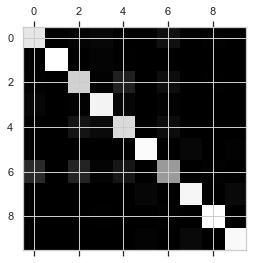

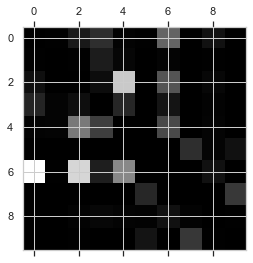


0.9901636444444446
0.8807


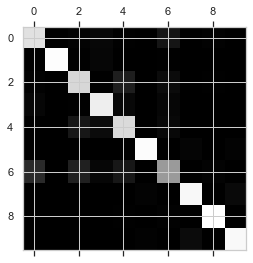

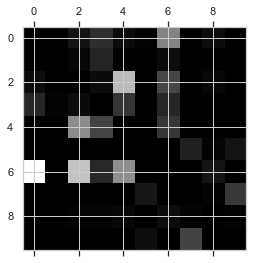


0.9908108555555556
0.8808


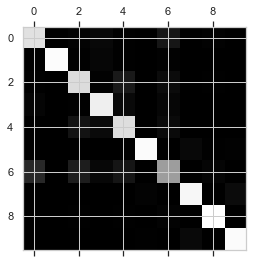

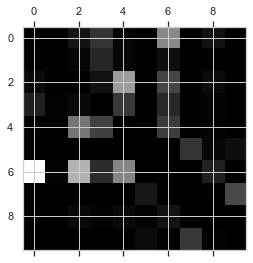


0.9908918722222223
0.8871


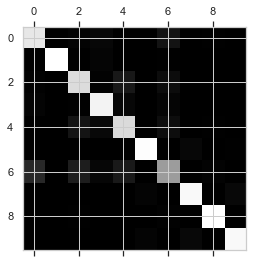

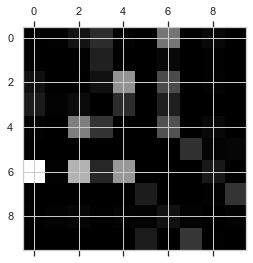


0.9905289333333334
0.8809


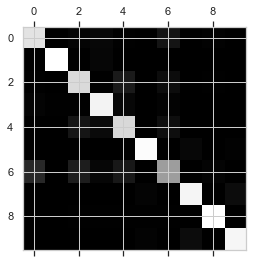

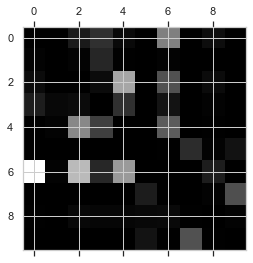


0.9899448777777777
0.8793


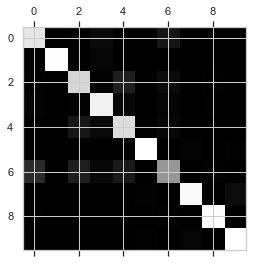

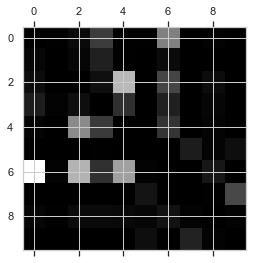

In [25]:
for train_index, test_index in skfolds.split(X_train, y_train):
    clone_clf = clone(rf_clf)
    X_train_folds = X_train.loc[train_index]
    y_train_folds = y_train.loc[train_index]
    X_test_fold = X_train.loc[test_index]
    y_test_fold = y_train.loc[test_index]

    std_scl = StandardScaler()
    std_scl.fit_transform(X_train_folds)
    std_scl.transform(X_test_fold)

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred_proba = clone_clf.predict_proba(X_test_fold)
    y_pred = clone_clf.predict(X_test_fold)
    print(metrics.roc_auc_score(y_test_fold, y_pred_proba, multi_class='ovr'))
    print(metrics.accuracy_score(y_test_fold, y_pred))
  #  n_correct = sum(y_pred == y_test_fold)
  #  print(n_correct / len(y_pred))
    conf_mx = metrics.confusion_matrix(y_test_fold, y_pred)
    plt.matshow(conf_mx, cmap=plt.cm.gray)
    plt.show()
    row_sums = conf_mx.sum(axis=1, keepdims=True)
    norm_conf_mx = conf_mx / row_sums
    np.fill_diagonal(norm_conf_mx, 0)
    plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
    plt.show()
    print()


When gaining insights on the training set I counted the values of each label.

Stratified sampling in cross validation ensures the training and test sets have the same proportion.

In [26]:
from sklearn.model_selection import cross_val_score

In [27]:
X_train_scaled = StandardScaler().fit_transform(X_train)

In [28]:
rf_cv = cross_val_score(rf_clf, X_train_scaled, y_train, cv=6, scoring='accuracy')

In [29]:
cross_val_score(knn_clf, X_train_scaled, y_train, cv=6, scoring='accuracy')

array([0.8592, 0.8537, 0.853 , 0.857 , 0.8522, 0.8528])

In [30]:
cross_val_score(log_reg, X_train_scaled, y_train, cv=6, scoring='accuracy')

array([0.853 , 0.8503, 0.8503, 0.8497, 0.8481, 0.8491])

In [31]:
rf_cv.mean()

0.8817666666666666

> #### Resources:
> 1. Fashion MNIST Dataset <a href="https://www.kaggle.com/zalando-research/fashionmnist"
> title="Kaggle">link</a>
> 2. Feature Scaling Article <a href="https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35"
> title="towardsdatascience">link</a>
